# Assignment 3
## Econ 8310 - Business Forecasting

For homework assignment 3, you will work with [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist), a more fancier data set.

- You must create a custom data loader as described in the first week of neural network lectures [2 points]
    - You will NOT receive credit for this if you use the pytorch prebuilt loader for Fashion MNIST!
- You must create a working and trained neural network using only pytorch [2 points]
- You must store your weights and create an import script so that I can evaluate your model without training it [2 points]

Highest accuracy score gets some extra credit!

Submit your forked repository URL on Canvas! :) I'll be manually grading this assignment.

Some checks you can make on your own:
- Did you manually process the data or use a prebuilt loader (see above)?
- Does your script train a neural network on the assigned data?
- Did your script save your model?
- Do you have separate code to import your model for use after training?

In [6]:
# This block is used to download the dataset from the source:
# https://github.com/zalandoresearch/fashion-mnist
# Since the data is already available in the 'fashion_dataset' folder,
# it is not necessary to run this part of the code for training.

import urllib.request
import os


tr_img = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz'
tr_labe = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz'
te_img = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz'
te_labe = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz'


os.makedirs('fashion_dataset', exist_ok=True)

urllib.request.urlretrieve(tr_img, f'fashion_dataset/train-images-idx3-ubyte.gz')
urllib.request.urlretrieve(tr_labe, f'fashion_dataset/train-labels-idx1-ubyte.gz')
urllib.request.urlretrieve(te_img, f'fashion_dataset/t10k-images-idx3-ubyte.gz')
urllib.request.urlretrieve(te_labe, f'fashion_dataset/t10k-labels-idx1-ubyte.gz')


('fashion_dataset/t10k-labels-idx1-ubyte.gz',
 <http.client.HTTPMessage at 0x2dbf2045670>)

In [1]:
def Custom_FashionMNIST_Loader(path):
    import os
    import gzip
    import numpy as np

    """This function reads the Training and Test datasets from the specified 'path'."""

    # Training
    with gzip.open(os.path.join(path, 'train-labels-idx1-ubyte.gz'), 'rb') as lb:
        y_train = np.frombuffer(lb.read(), dtype=np.uint8, offset=8)

    with gzip.open(os.path.join(path, 'train-images-idx3-ubyte.gz'), 'rb') as img:
        X_train = np.frombuffer(img.read(), dtype=np.uint8, offset=16).reshape(len(y_train), 784)

    # Test
    with gzip.open(os.path.join(path, 't10k-labels-idx1-ubyte.gz'), 'rb') as lb:
        y_test = np.frombuffer(lb.read(), dtype=np.uint8, offset=8)

    with gzip.open(os.path.join(path, 't10k-images-idx3-ubyte.gz'), 'rb') as img:
        X_test = np.frombuffer(img.read(), dtype=np.uint8, offset=16).reshape(len(y_test), 784)

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = Custom_FashionMNIST_Loader('fashion_dataset')


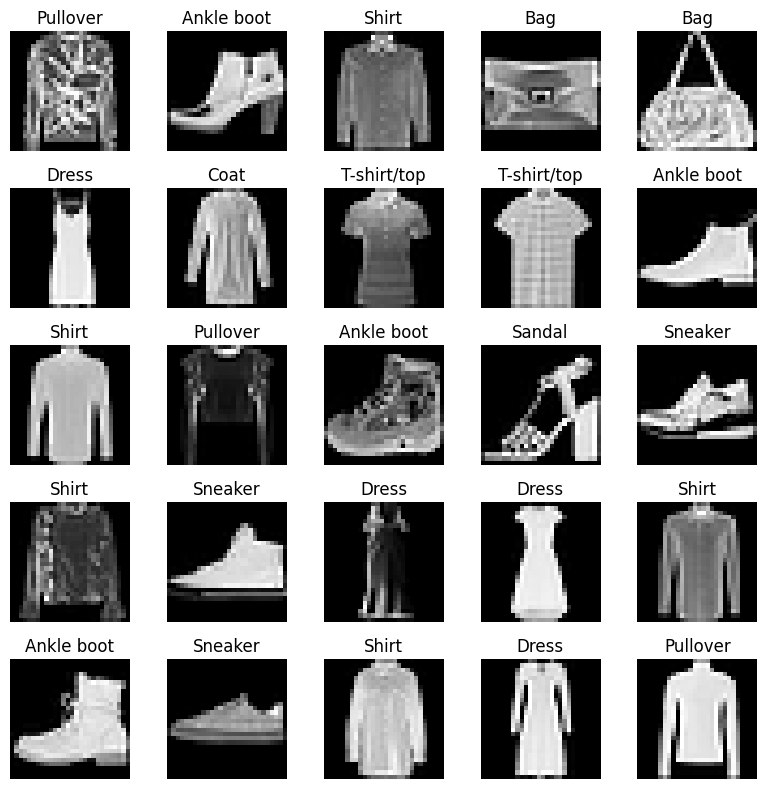

In [3]:
# I plotted the data to be sure that the images and labels were correctly loaded.

import matplotlib.pyplot as plt
import numpy as np

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

random_indices = np.random.choice(len(X_train), size=25, replace=False)

plt.figure(figsize=(8, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[idx].reshape(28, 28), cmap='gray')
    plt.title(class_names[y_train[idx]])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels, augment=False):
        self.images = torch.tensor(images, dtype=torch.float32).reshape(-1, 1, 28, 28) / 255.0
        self.labels = torch.tensor(labels, dtype=torch.long)

        if augment:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10)
            ])
        else:
            self.transform = None

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx].cuda(), self.labels[idx].cuda()

train_dataset = FashionMNISTDataset(X_train, y_train)
test_dataset = FashionMNISTDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [3]:
from nnhelpers_modified import train_loop, test_loop, train_net

class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1, dropout=0.0):
        super(Residual, self).__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.dropout = nn.Dropout2d(dropout)
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.dropout(Y)
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)


class ResNet(nn.Module):
    def __init__(self, arch, lr=0.1, num_classes=10, dropout=0.0):
        super(ResNet, self).__init__()
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.net.add_module(f'b{i+2}',
                self.block(*b, first_block=(i==0), dropout=dropout))
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),nn.Dropout(dropout),
            nn.LazyLinear(num_classes)))

    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def block(self, num_residuals, num_channels, first_block=False, dropout=0.0):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels,
                 use_1x1conv=True, strides=2, dropout=dropout))
            else:
                blk.append(Residual(num_channels, dropout=dropout))
        return nn.Sequential(*blk)

    def forward(self, x):
        x = self.net(x)
        return x

class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10, dropout=0.5):
        super(ResNet18, self).__init__(((2, 64), (2, 128),
         (2, 256), (2, 512)),
                       lr, num_classes, dropout=dropout)

model = ResNet18().to('cuda')

C:\Users\mroudsari2\Anaconda33\envs\torch_env\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Run the next block only to train the dataset and save the model. To load the saved model, use the blocks preceding this section and those following the next block.

In [13]:
model = train_net(model, train_dataloader, test_dataloader,
                  epochs=30, learning_rate=1e-4, batch_size=64)

torch.save(model.state_dict(), 'Trained_Model_fashionMNIST_resnet18_dropout.pth')

Epoch 1
-------------------------------
loss: 2.819378  [   64/60000]
loss: 2.651006  [  704/60000]
loss: 2.481688  [ 1344/60000]
loss: 2.328755  [ 1984/60000]
loss: 2.462894  [ 2624/60000]
loss: 2.382839  [ 3264/60000]
loss: 2.289181  [ 3904/60000]
loss: 2.127778  [ 4544/60000]
loss: 2.029170  [ 5184/60000]
loss: 1.994216  [ 5824/60000]
loss: 1.591005  [ 6464/60000]
loss: 1.467335  [ 7104/60000]
loss: 1.605666  [ 7744/60000]
loss: 1.454002  [ 8384/60000]
loss: 1.420883  [ 9024/60000]
loss: 1.313364  [ 9664/60000]
loss: 1.502951  [10304/60000]
loss: 1.283563  [10944/60000]
loss: 1.317977  [11584/60000]
loss: 1.116516  [12224/60000]
loss: 1.521580  [12864/60000]
loss: 1.106937  [13504/60000]
loss: 1.293971  [14144/60000]
loss: 0.919304  [14784/60000]
loss: 1.031729  [15424/60000]
loss: 0.914045  [16064/60000]
loss: 1.022111  [16704/60000]
loss: 0.832962  [17344/60000]
loss: 0.886675  [17984/60000]
loss: 0.811860  [18624/60000]
loss: 1.015569  [19264/60000]
loss: 0.792143  [19904/60000]


In [15]:
model = train_net(model, train_dataloader, test_dataloader,
                  epochs=10, learning_rate=1e-4, batch_size=64)

Epoch 41
-------------------------------
loss: 0.235854  [   64/60000]
loss: 0.127294  [  704/60000]
loss: 0.171857  [ 1344/60000]
loss: 0.117219  [ 1984/60000]
loss: 0.122641  [ 2624/60000]
loss: 0.041131  [ 3264/60000]
loss: 0.094798  [ 3904/60000]
loss: 0.047461  [ 4544/60000]
loss: 0.127100  [ 5184/60000]
loss: 0.166388  [ 5824/60000]
loss: 0.086882  [ 6464/60000]
loss: 0.165028  [ 7104/60000]
loss: 0.302822  [ 7744/60000]
loss: 0.093313  [ 8384/60000]
loss: 0.159726  [ 9024/60000]
loss: 0.070048  [ 9664/60000]
loss: 0.060592  [10304/60000]
loss: 0.096488  [10944/60000]
loss: 0.132220  [11584/60000]
loss: 0.156359  [12224/60000]
loss: 0.132595  [12864/60000]
loss: 0.030394  [13504/60000]
loss: 0.049550  [14144/60000]
loss: 0.149849  [14784/60000]
loss: 0.069050  [15424/60000]
loss: 0.261114  [16064/60000]
loss: 0.179416  [16704/60000]
loss: 0.086094  [17344/60000]
loss: 0.179800  [17984/60000]
loss: 0.336379  [18624/60000]
loss: 0.071156  [19264/60000]
loss: 0.060839  [19904/60000]

In [16]:
torch.save(model.state_dict(), 'Trained_Model_fashionMNIST_resnet18_dropout.pth')

# Loading the saved model

In [4]:
import torch
from torch.utils.data import DataLoader
from nnhelpers_modified import train_loop, test_loop, train_net

X_train, y_train, X_test, y_test = Custom_FashionMNIST_Loader('fashion_dataset')
test_dataset = FashionMNISTDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64)

model = ResNet18().to('cuda')
model.load_state_dict(torch.load('Trained_Model_fashionMNIST_resnet18_dropout.pth'))
model.eval()

loss_fn = torch.nn.CrossEntropyLoss()
test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.281631 

